In [85]:
import requests as re
from bs4 import BeautifulSoup
from csv import writer
from datetime import date, timedelta
import pandas as pd
import numpy as np
import warnings
from IPython.core.interactiveshell import InteractiveShell


InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings('ignore')

pd.set_option('display.width', 1000000)
pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)


fund_id_map = {
    'AXIS': 53,
    'CANARA': 32,
    'MIRAE': 45,
    'PPFAS': 64,
    'QUANT': 13,
#     'MOTI': 55,
#     'UTI': 28,
#     'NIPPON': 21
} 

fund_scheme_map = {    
    'AXIS': { 
        'axis_long_term_equity': 120503,
#         'axis_small_cap': 125354,
#         'axis_mid_cap': 120505,
#         'axis_flexi_cap': 141925,        
#         'axis_bluechip': 120465
    },
    'CANARA': {
        'canara_emerging_equities': 118278
    },
    'MIRAE': {
        'mirae_tax_saver': 135781
    },
    'PPFAS': {
        'ppfas_flexi_cap': 122639
    },
    'QUANT': {
        'quant_active_fund': 120823
    },
#     'MOTI': {
#         'moti_nifty_200_momentum': 149800
#     },
#     'UTI': {
#         'uti_midcap_quality_50': 150313
#     },
#     'NIPPON': {
#         'nippon_alpha_low_volatility': 150487
#     }
}



In [65]:

st_dt = date(2016, 1, 1)
en_dt = st_dt.replace(year=st_dt.year +4)



def fetch_and_write():
    for fund, mfID in fund_id_map.items():
        for scheme ,scID in fund_scheme_map[fund].items():
            
            start_dt = st_dt
            end_dt = en_dt
            
            while start_dt < date.today():
                resp = fetch(mfID, scID, start_dt, end_dt)            
                soup = BeautifulSoup(resp.content)            
                
                start_dt = end_dt + timedelta(days =1)
                end_dt = end_dt.replace(year = end_dt.year +4)
                
                
                for child in soup.find_all('tbody')[0].find_all('tr'):
                    td_list = child.find_all('td')

                    if(len(td_list) !=4 ):
                       continue

                    x = [td_list[3].string, td_list[0].string]
                    with open("{}.csv".format(scheme), 'a') as f_object:
                        writer_object = writer(f_object)
                        writer_object.writerow(x)
                        f_object.close()                                                
                
            
def fetch(mfID, scID, sDate, eDate):
    url = 'https://www.amfiindia.com/modules/NavHistoryPeriod'    
    
    data = {
      'mfID': mfID,
      'scID': scID,
      'fDate': sDate.strftime('%d-%b-%Y'),
      'tDate': eDate.strftime('%d-%b-%Y'),
    }

    return re.post(url = url, data =data)
    

fetch_and_write()


In [99]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

out = pd.DataFrame(columns=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']);

final_df = pd.DataFrame()

def multi_period_return(period_returns):
 return np.prod(period_returns + 1) - 1

for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():
        df = pd.read_csv('{}.csv'.format(scheme), names= ['date', 'nav'], parse_dates=['date'], index_col = ['date'])
        df = df.iloc[500:, :]
        df['nav'] = df['nav']/df['nav'].max()
        pr = df.pct_change()
  
        df['1yr_roll_ret'] = pr.rolling('360D').apply(multi_period_return).mul(100)
        df['2yr_roll_ret'] = pr.rolling('720D').apply(multi_period_return).mul(100)
        df['3yr_roll_ret'] = pr.rolling('1080D').apply(multi_period_return).mul(100)
        df['5yr_roll_ret'] = pr.rolling('1800D').apply(multi_period_return).mul(100)
        df['cum_return']   = pr.add(1).cumprod().sub(1).mul(100)
        df['fund']=scheme
        final_df = pd.concat([final_df, df])
        
        
#         out.loc[scheme] = df['1yr_roll_ret'].iloc[245:].describe().values

final_df = final_df.iloc[1:,:]

In [102]:
ans = pd.DataFrame()

for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():
#         data = final_df[final_df['fund'] == scheme]['1yr_roll_ret'].describe()
        
#         data['1yr_roll_ret'] = final_df[final_df['fund'] == scheme]['1yr_roll_ret'].describe()
#         data['2yr_roll_ret'] = final_df[final_df['fund'] == scheme]['2yr_roll_ret'].describe()
#         data['3yr_roll_ret'] = final_df[final_df['fund'] == scheme]['3yr_roll_ret'].describe()        
#         data['fund'] = scheme        
          data = final_df[final_df['fund'] == scheme]['2yr_roll_ret'].describe()
#         print(data.transpose())
          data['fund'] = scheme
                  
          ans = ans.append(data.transpose())
#           
        
ans = ans.reset_index()
ans = ans.set_index(['fund','index'])
ans = ans.loc[:, ~ans.columns.isin(['count'])]

print(ans[['min','max','25%','mean','50%','75%','std']])


                                          min      max    25%    mean     50%      75%     std
fund                     index                                                                
axis_long_term_equity    2yr_roll_ret -14.230   91.260  1.907  22.819  15.978   44.162  24.027
canara_emerging_equities 2yr_roll_ret -25.943  128.354 -6.386  23.985   0.572   59.135  36.790
mirae_tax_saver          2yr_roll_ret -21.566  145.427 -2.032  29.006  12.040   61.767  35.563
ppfas_flexi_cap          2yr_roll_ret -12.538  148.342  3.448  34.616  15.147   60.760  37.188
quant_active_fund        2yr_roll_ret -29.528  227.109 -3.114  44.729   5.974  100.511  59.505


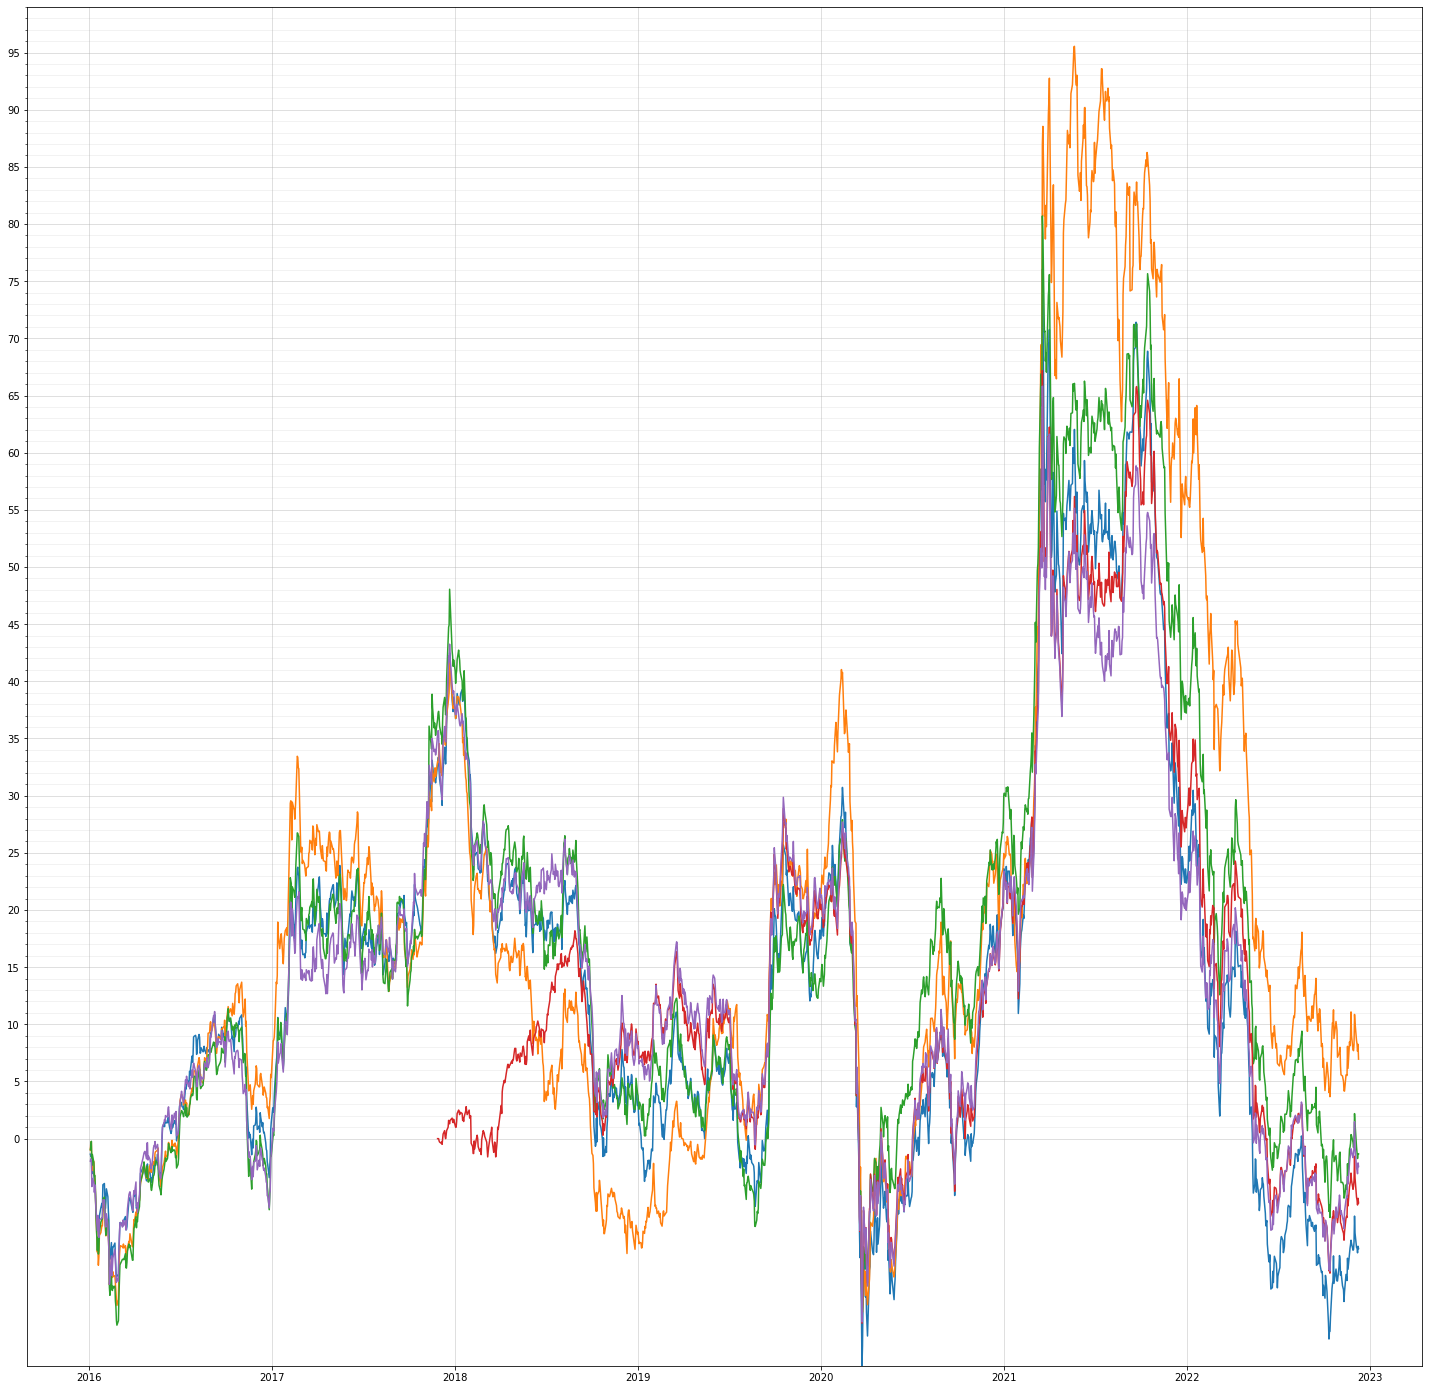

In [135]:
import matplotlib.pyplot as plt

pdf = final_df


fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(1, 1, 1)
plt.ylim(pdf["1yr_roll_ret"].min(), pdf["1yr_roll_ret"].max())
major_ticks = np.arange(0, 100, 5)
minor_ticks = np.arange(0, 100, 1)

# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


for fund, mfID in fund_id_map.items():
    for scheme ,scID in fund_scheme_map[fund].items():

        plt.plot(
            pdf[pdf['fund']==scheme].index,
            pdf[pdf['fund']==scheme]["1yr_roll_ret"]
        )


# plt.plot(
#     pdf.iloc[246:].index,
#     pdf.iloc[246:]["2yr_roll_ret"]
# )

# plt.plot(
#     pdf.iloc[492:].index,
#     pdf.iloc[492:]["3yr_roll_ret"]
# )


# plt.axhline(y = pdf["1yr_roll_ret"].mean())
# plt.axhline(y = pdf.iloc[246:]["2yr_roll_ret"].mean())
# plt.axhline(y = 0)


# plt.plot(
#     pdf.index,
#     pdf["cum_return"]
# )


plt.show()

In [37]:
## https://www.hdfcpension.com/nav/nav-history/

import random
import string

nps_start_dt = date(2016, 8, 1)
nps_end_dt = date.today()
char_set = string.ascii_uppercase + string.digits
#nonce = ''.join(random.sample(char_set*10, 10))
    
def fetch_nps():
    nps_url = 'https://www.hdfcpension.com/wp-admin/admin-ajax.php'
    
    nps_data = {
      'action': 'nav_get',
      'nonce': 'ab08f277c5',
      'from_date': nps_start_dt.strftime('%Y-%m-%d'),
      'to_date': nps_end_dt.strftime('%Y-%m-%d'),
    }

    return re.post(url = nps_url, data =nps_data)
    
nps_res = fetch_nps()
soup = BeautifulSoup(nps_res.content)
print(soup.get_text())
#print(soup.find_all('tr'))



    


{"success":true,"data":"\n          \n            \n           \n           \n\n            Date<\/th>\n            HDFC Pension Fund Scheme Tier I<\/th>\n            HDFC Pension Fund Scheme Tier II<\/th>\n\t    NPS LITE SCHEME <\/th>\n            <\/tr>\n\n                \n                     <\/th>\n                     E<\/th>\n                     C<\/th>\n                     G<\/th>\n                     A<\/th>\n                     E<\/th>\n                     C<\/th>\n                     G<\/th>\n                     A<\/th>\n                     TAX SAVER SCHEME<\/th>\n\t\t    <\/th>\n                <\/tr>\n      \n                     \n                             \n                          01-08-2016<\/td>\n                          16.161<\/td>\n                          14.1912<\/td>\n                          14.2926<\/td>\n                           - <\/td>\n                          13.9543<\/td>\n                          13.3488<\/td>\n                     